# Comparative Analysis of Image Colorization Techniques
## 0. Setup
Install the envvironment with following command: 

In [25]:
!conda env create -f environment.yml


CondaValueError: prefix already exists: /home/karl/miniconda3/envs/cv



In [13]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from PIL import Image

import utils.image_process as ip
from model.GAN.network import Generator as GAN
from model.diffusion.diffusion import GaussianDiffusion
from model.diffusion.network import UNet
from model.CNN.network import ColorizationNet as CNN
from model.CNN.training_loop import merge_l_ab

# Set the device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Load the best model
pth_CNN = torch.load("experimental_results/CNN2/checkpoint/checkpoint_15.pth", map_location=device)
pth_GNN = torch.load("experimental_results/GNN/checkpoint/checkpoint_18.pth", map_location=device)
pth_Diffusion = torch.load("experimental_results/diffusion2/checkpoint/epoch_18.pth", map_location=device)
# CNN model
cnn = CNN().to(device)
cnn.load_state_dict(pth_CNN)
# GAN model
gan = GAN().to(device)
gan.load_state_dict(pth_GNN['generator'])
# Diffusion model
denoise = UNet().to(device)
denoise.load_state_dict(pth_Diffusion['denoise_model'])
# denoise.eval()
diffusion = GaussianDiffusion(denoise, betas = torch.linspace(start=1e-4, end=2e-2, steps=1000, device=device)).to(device)
diffusion.load_state_dict(pth_Diffusion['model'])

def fit_plt(img):
    # Sqeeze the first dimension if it has 4 dimensions
    if img.dim() == 4:
        img = img.squeeze(0)
    # Grayscale to RGB format
    if img.shape[0] == 1:
        img = img.repeat(3, 1, 1)
    # Rearrange the dimensions
    img = img.permute(1, 2, 0)
    # Postprocess the image
    img = ip.postprocess(img)
    img = img.detach().cpu().numpy()

    return img

We start by load an example image from validation set.

In [9]:
example_image = Image.open("example.png")

## 1. CNN coloration

/home/karl/final_project_3dcv/model/CNN/training_loop.py:59: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  rgb_images_np = [lab2rgb(lab_img) for lab_img in lab_images_np]


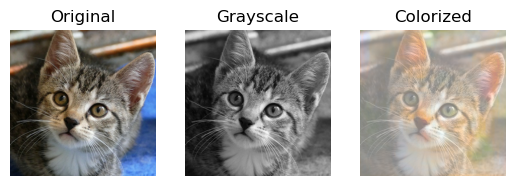

In [21]:
image = ip.basic_transform(example_image).unsqueeze(0).to(device)
grayscale_images = TF.rgb_to_grayscale(image)
grayscale_images = (grayscale_images + 1.0) / 2.0
outputs_ab = cnn(grayscale_images)
l_channel = grayscale_images.expand(-1, 3, -1, -1)
outputs = merge_l_ab(l_channel[:, :1, :, :], outputs_ab)

# Display the images
fig, ax = plt.subplots(1, 3)
ax[0].imshow(fit_plt(image))
ax[1].imshow(fit_plt(grayscale_images * 2 - 1))
ax[2].imshow(fit_plt(outputs))

ax[0].set_title("Original")
ax[1].set_title("Grayscale")
ax[2].set_title("Colorized")

ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")
plt.show()

## 2. GNN coloration

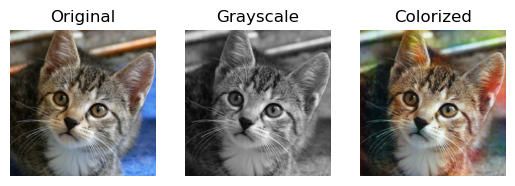

In [22]:
image = ip.basic_transform(example_image)
image_grayscale = TF.rgb_to_grayscale(image).unsqueeze(0).to(device)

# Generate the image
generated = gan(image_grayscale)

# Display the images in a plot
fig, ax = plt.subplots(1, 3)
ax[0].imshow(fit_plt(image))
ax[1].imshow(fit_plt(image_grayscale))
ax[2].imshow(fit_plt(generated))

ax[0].title.set_text("Original")
ax[1].title.set_text("Grayscale")
ax[2].title.set_text("Colorized")

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

## 3. Diffusion coloration

/home/karl/final_project_3dcv/utils/image_process.py:74: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 34 negative Z values that have been clipped to zero
  rgb_batch_np[i] = color.lab2rgb(lab_batch_np[i])
/home/karl/final_project_3dcv/utils/image_process.py:74: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 14414 negative Z values that have been clipped to zero
  rgb_batch_np[i] = color.lab2rgb(lab_batch_np[i])


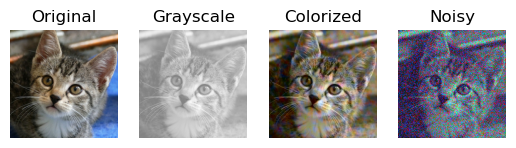

In [23]:
image = ip.basic_transform(example_image)
input_image = ip.transform_grayscale(example_image).unsqueeze(0)
input_image = ip.rgb_to_lab(input_image).to(device)

# Perform inference
output, noisy = diffusion.reverse_diffusion(input_image, True)
output = ip.lab_to_rgb(output)
noisy = ip.lab_to_rgb(noisy)

# Display the images in a plot
fig, ax = plt.subplots(1, 4)
ax[0].imshow(fit_plt(image))
ax[1].imshow(fit_plt(input_image[:, 0, :, :]))
ax[2].imshow((output[0]))
ax[3].imshow((noisy[0]))

ax[0].title.set_text("Original")
ax[1].title.set_text("Grayscale")
ax[2].title.set_text("Colorized")
ax[3].title.set_text("Noisy")

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[3].axis('off')
plt.show()